To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
follow: https://github.com/cosmo-epfl/librascal
+ from terminal execute " git clone https://github.com/lab-cosmo/librascal.git "
+ cd librascal
+ pip install --user .

In [3]:
#!pip install --user scikit-learn
!module list

1h=
Currently Loaded Modules:
  1) StdEnv            5) cudnn/8.2.1.32      9) git/2.31.1
  2) gcc/8.2.0         6) nccl/2.11.4-1      10) jupyterlab/3.5.1
  3) openblas/0.3.15   7) python_gpu/3.10.4  11) eth_proxy
  4) cuda/11.3.1       8) npm/6.14.9         12) r/4.2.2

 

>

In [1]:
## use in case missing interactive plt libr
%matplotlib inline

## use in jupyter notebooks to activate interactive plt
#%matplotlib notebook  

## use in jupyter lab to activate interactive plt
#%matplotlib widget      
from matplotlib import pylab as plt

import os, sys
from ase.io import read
#sys.path.insert(0,"../build/")

import sys
import time
import rascal
import json

import nglview

import ipywidgets as ipw
from IPython.display import display, clear_output, HTML

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view

#import nglview

import numpy as np
import sys

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel

## load a set of Al-O-N structures (traj.xyz) and the corresponding DFT energies (etotsorted.dat). Apply PBC to the structures and wrap atomic positions

In [2]:
# load the trajectory
framestot= read('traj.xyz',':')

# apply the PBC to the box
for i in framestot:
    i.pbc=True
    # Atoms should be wrapped within the cell, so let's just apply the PBC and wrap them
    i.wrap(eps=1e-11)
    
# load the corresponding total energies
entotfull=np.loadtxt("entotsorted.dat")

## Select N structures randomly from the set

In [4]:
# test it on a random sample
import random as rnd
from operator import itemgetter 

# get a random set, N structures
N=200
idrnd=np.asarray(rnd.sample(list(range(len(framestot))),N))
frames=list(itemgetter(*idrnd.tolist())(framestot))

# get the corresponding energies
entot=np.asarray(list(itemgetter(*idrnd.tolist())(entotfull)))

# Make a map of the dataset (not working on this docker)

## utils

In [10]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [5]:
# SOAP parameters

hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )

#hypers = dict(soap_type="PowerSpectrum",
#              interaction_cutoff=5, 
#              max_radial=6, 
#              max_angular=6, 
#              gaussian_sigma_constant=0.6,
#              gaussian_sigma_type="Constant",
#              cutoff_smooth_width=0.5,
#              n_species=3
#              )

# Define the model
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap,name='Cosine', zeta=2, target_type='Structure', kernel_type='Full')

In [6]:
# Compute the SOAPS 
managers = soap.transform(frames)

In [7]:
# and get the global similarity matrix (NxN matrix)
Kmat = kernel(managers)

In [8]:
print(len(frames))

200


In [9]:
from sklearn.decomposition import KernelPCA

In [11]:
# apply the dimensionality reduction. Step 1: fit the model
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(Kmat)

KernelPCA(kernel='precomputed', n_components=2)

In [12]:
# Step 2 : project in low dimension the HD data using the kpca just trained
X = kpca.transform(Kmat)

In [15]:
print(Kmat.shape)
print(X.shape)

(200, 200)
(200, 2)


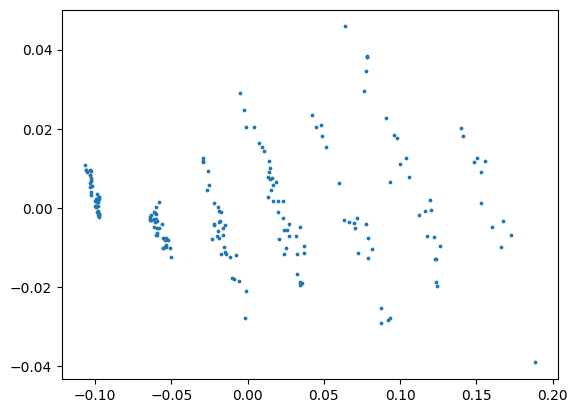

In [16]:
plt.scatter(X[:,0],X[:,1],s=3)

## make an interactive map (not working with this docker)

In [ ]:
## #package to visualize the structures in the notebook
## https://github.com/arose/nglview#released-version


In [17]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

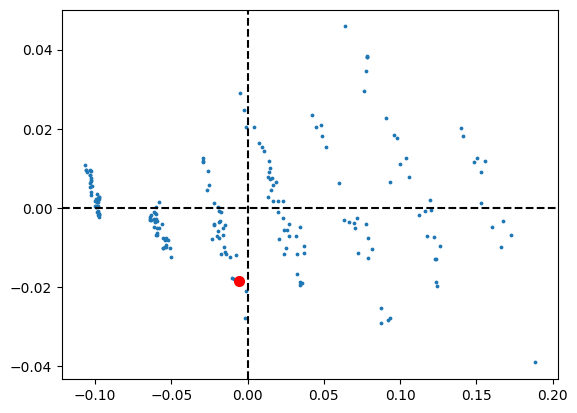

NGLWidget(max_frame=199)

In [18]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
plt.show()
iwdg

## patch: plot selected frame

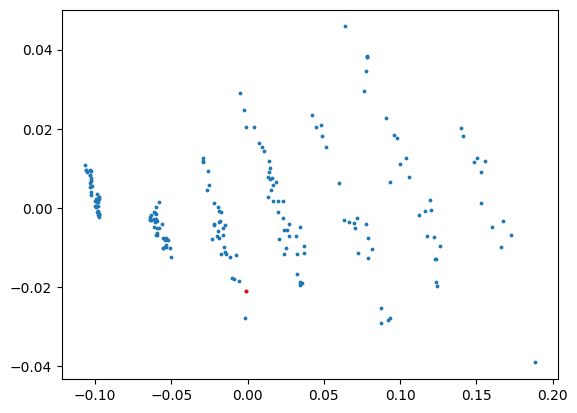

In [22]:
frame=50
plt.scatter(X[:,0],X[:,1],s=3)
plt.scatter(X[frame,0],X[frame,1],s=3,c='red')
a=view(frames[frame], viewer='ngl')

In [23]:
ou=ipw.Output()
idf=ipw.IntSlider(
    value=7,
    min=0,
    max=N-1,
    step=1,
    description='frame:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(idf,ou)

def on_frame_change(change):
    with ou:
        clear_output()
        val=idf.value
        plt.scatter(X[:,0],X[:,1],s=3)
        plt.scatter(X[val,0],X[val,1],s=3,c='red')
        plt.show()
        #display(view(frames[val], viewer='ngl'))
        v=view(frames[val], viewer='ngl')
        #v=_
        while hasattr(v.view, "component_0"):
            v.view.component_0.clear_representations()
            cid = v.view.component_0.id
            v.view.remove_component(cid)
        v.view.add_component(nglview.ASEStructure(frames[val]), 
                     default_representation=False)
        v.view.add_ball_and_stick(aspectRatio=2.0, opacity=1.0,component=0)
        v.view.add_unitcell()
        v.view.center() 
        display(v)
idf.observe(on_frame_change,names='value')

IntSlider(value=7, continuous_update=False, description='frame:', max=199)

Output()

## PLOT the cohesive energy on top of the map

## getnatms determines the number of Al,N,O for each frame

In [24]:
# get the partial numbers of atoms
def getnatms(frm):
    tmp=np.asarray([len(np.where(frm.get_atomic_numbers()==13)[0]),len(np.where(frm.get_atomic_numbers()==7)[0]),len(np.where(frm.get_atomic_numbers()==8)[0])])
    return tmp

## identify pure AlN and pure Al2O3 to compute cohesive energy. The supercell of AlN contains 96 formula units while the supercell of Al2O3 contains 48 formula units

In [25]:
# get ref energies
natms=np.asarray([getnatms(i) for i in framestot])
idxALN=np.where(natms[:,2]==0)
idxAL2O3=np.where(natms[:,1]==0)
enALN=entotfull[idxALN][0]/96.
enAL2O3=entotfull[idxAL2O3][0]/48.

In [26]:
# get the numbers just for the subset
natms=np.asarray([getnatms(i) for i in frames])
#idxALN=np.where(natms[:,2]==0)
#idxAL2O3=np.where(natms[:,1]==0)

## compute cohesive energy per atom  as $(E_{i} -n_N \mu _{AlN} - n_O \mu _{Al_2 O_3})/n_{atoms}$ 

In [27]:
def get_encoes(etot,ealn,eal2o3,atms):
    return (etot-atms[1]*ealn-atms[2]*eal2o3/3.)/atms.sum()

In [28]:
# get the coesive energy
ecoes=np.asarray([get_encoes(en,enALN,enAL2O3,natms[i]) for i,en in enumerate(entot)])

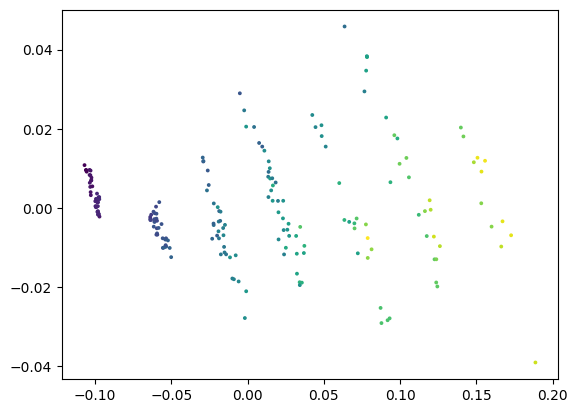

In [29]:
# color the points according to the coesive energy
plt.scatter(X[:,0],X[:,1],s=3,c=ecoes)

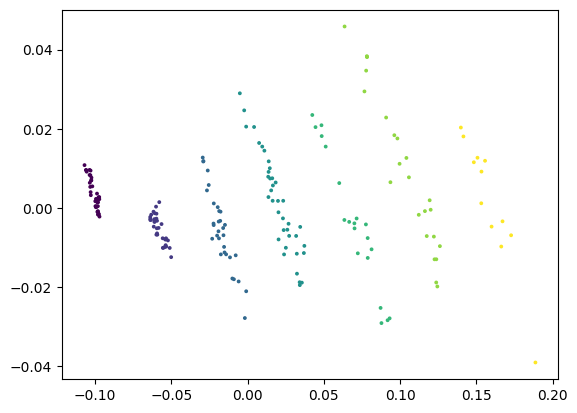

In [30]:
plt.scatter(X[:,0],X[:,1],s=3,c=natms[:,2])